+-----------+-----+
|PassengerID|count|
+-----------+-----+
| UES9151GS5|   25|
| DAZ3029XA0|   23|
| PUD8209OG3|   23|
| SPR4484HA6|   23|
| BWI0520BG6|   23|
| HCA3158QA6|   21|
| EZC9678QI6|   21|
| JJM4724RF7|   21|
| WBE6935NU3|   19|
| POP2875LH3|   19|
+-----------+-----+
only showing top 10 rows

+-----------------+---------------+
|      AirportName|DeparturesCount|
+-----------------+---------------+
|             ROME|             15|
|          BEIJING|             13|
|            PARIS|             21|
|          HOUSTON|             37|
|         SHANGHAI|             20|
|           MUNICH|             14|
|     KUALA LUMPUR|             33|
|        LAS VEGAS|             17|
|        AMSTERDAM|             15|
|           DENVER|             46|
|        CHARLOTTE|             21|
|            MIAMI|             11|
|           LONDON|             25|
|DALLAS/FORT WORTH|             11|
|          BANGKOK|             17|
|          JAKARTA|             27|
|        G

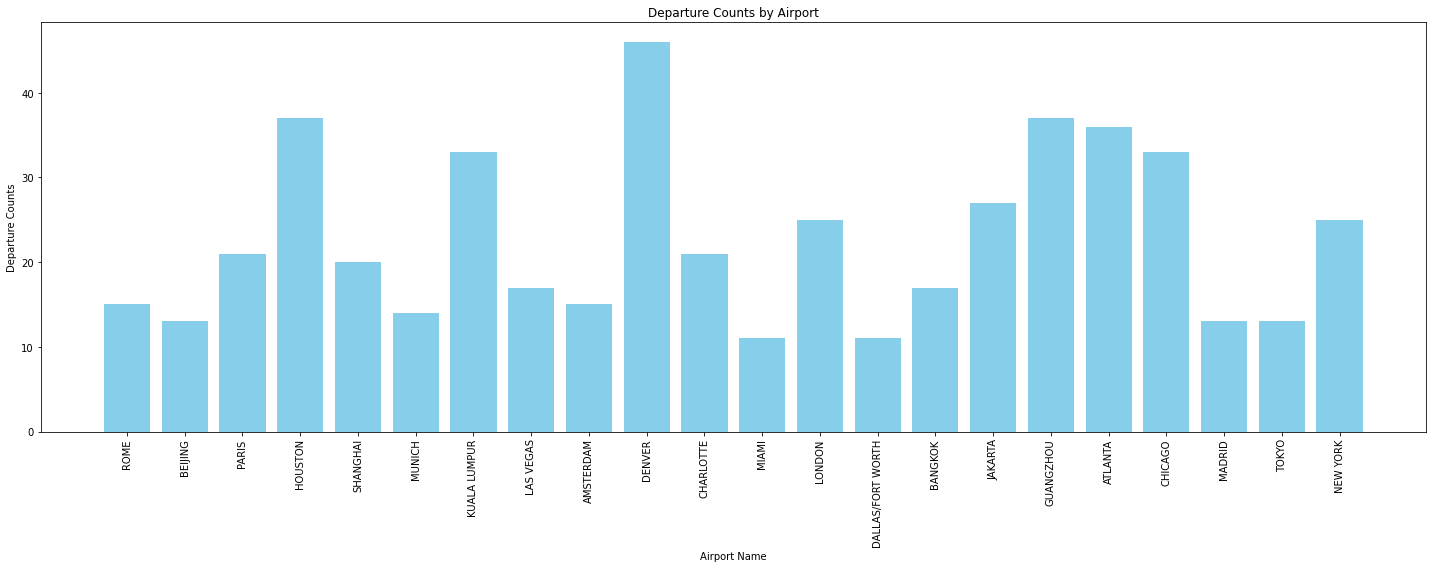

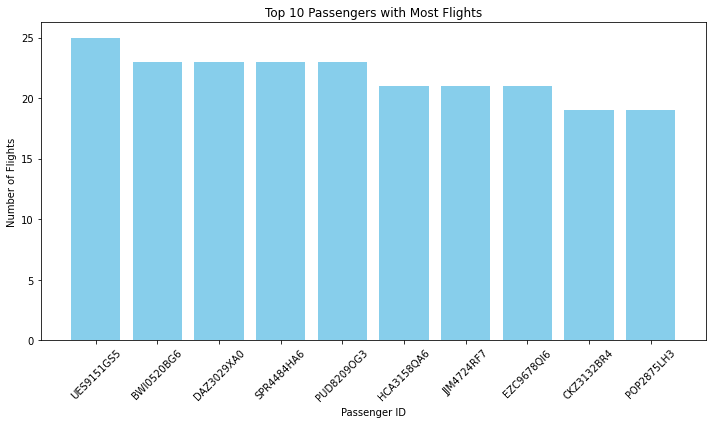

In [24]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType
import matplotlib.pyplot as plt
import pandas as pd

# 初始化 SparkSession
spark = SparkSession.builder \
    .appName("Flight Data Analysis") \
    .master("local") \
    .getOrCreate()

# 航班数据路径和机场数据路径
flights_file = 'hdfs://localhost:9000/user/zsy/AComp_Passenger_data_no_error.csv'
airports_file = 'hdfs://localhost:9000/user/zsy/Top30_airports_LatLong.csv'

# 定义航班数据和机场数据的 schema
flight_schema = StructType([
    StructField("PassengerID", StringType(), True),
    StructField("FlightID", StringType(), True),
    StructField("DepartureCode", StringType(), True),
    StructField("DestinationCode", StringType(), True),
    StructField("DepartureTime", IntegerType(), True),
    StructField("FlightTime", IntegerType(), True)
])

airport_schema = StructType([
    StructField("AirportName", StringType(), True),
    StructField("IATACode", StringType(), True),
    StructField("Latitude", DoubleType(), True),
    StructField("Longitude", DoubleType(), True)
])

# 加载航班数据和机场数据，使用显式定义的 schema
flights_data = spark.read.csv(flights_file, header=False, schema=flight_schema)
airports_data = spark.read.csv(airports_file, header=False, schema=airport_schema)

# 根据机场代码统计每个机场的出发航班数量
airport_departures = flights_data.groupBy("DepartureCode").count().withColumnRenamed("count", "DeparturesCount")

# 连接机场数据，获取机场名称
# 使用正确的连接条件，将 DepartureCode 与 IATACode 匹配
airport_departures = airport_departures.join(airports_data, airport_departures["DepartureCode"] == airports_data["IATACode"], "left_outer") \
    .select("AirportName", "DeparturesCount")

# 统计每位乘客的航班次数
passenger_flights = flights_data.groupBy("PassengerID").count().orderBy(col("count").desc())
passenger_flights.show(10)


# 显示结果
airport_departures.show()

# 可视化机场的出发航班数量
pd_departures = airport_departures.toPandas()
plt.figure(figsize=(20, 8))  # 增加图形的尺寸
plt.bar(pd_departures['AirportName'], pd_departures['DeparturesCount'], color='skyblue')
plt.xlabel('Airport Name')
plt.ylabel('Departure Counts')
plt.title('Departure Counts by Airport')
plt.xticks(rotation=90)  # 将标签旋转90度以提高可读性
plt.tight_layout()  # 自动调整布局
plt.show()

# 先转换 Spark DataFrame 到 Pandas DataFrame
pd_passenger_flights = passenger_flights.limit(10).toPandas()

# 绘制条形图
plt.figure(figsize=(10, 6))
plt.bar(pd_passenger_flights['PassengerID'], pd_passenger_flights['count'], color='skyblue')
plt.xlabel('Passenger ID')
plt.ylabel('Number of Flights')
plt.title('Top 10 Passengers with Most Flights')
plt.xticks(rotation=45)
plt.tight_layout()  # 自动调整子图参数, 使之填充整个图像区域
plt.show()